<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S6/EVA4_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sys
import numpy as np

## Get Train and Test data

In [0]:
def get_train_test():
    ##Train Phase transformations
    train_transforms = transforms.Compose([
        #  transforms.Resize((28, 28)),
        #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
        # Note the difference between (0.1307) and (0.1307,)
    ])

    ##Test Phase transformations
    test_transforms = transforms.Compose([
        #  transforms.Resize((28, 28)),
        #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    ##Dataset and creating train/test split
    train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
    test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

    ##Dataloader Arguments & Test/Train Dataloaders
    SEED = 1

    # CUDA?
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)

    # For reproducibility
    torch.manual_seed(SEED)

    if cuda:
        torch.cuda.manual_seed(SEED)

    # dataloader arguments - something you'll fetch these from cmdprmt
    dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True,
                                                                                                          batch_size=64)

    # train dataloader
    train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

    # test dataloader
    test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

    return train_loader, test_loader, test


##Ghost Batch Normalisation Class

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
      try:
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)
      except Exception as e:
        raise Exception('GBN: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

#Base Model

In [0]:
class Net(nn.Module):
    def __init__(self, requiredBN, requiredGBN):
        super(Net, self).__init__()
        self.requiredBN = requiredBN
        self.requiredGBN = requiredGBN

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN1 = nn.BatchNorm2d(10)
        if self.requiredGBN is True:
            self.GBN1 = GhostBatchNorm(num_features=10, num_splits=2)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN2 = nn.BatchNorm2d(10)
        if self.requiredGBN is True:
            self.GBN2 = GhostBatchNorm(num_features=10, num_splits=2)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN3 = nn.BatchNorm2d(16)
        if self.requiredGBN is True:
            self.GBN3 = GhostBatchNorm(num_features=16, num_splits=2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN4 = nn.BatchNorm2d(16)
        if self.requiredGBN is True:
            self.GBN4 = GhostBatchNorm(num_features=16, num_splits=2)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN5 = nn.BatchNorm2d(16)
        if self.requiredGBN is True:
            self.GBN5 = GhostBatchNorm(num_features=16, num_splits=2)

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        if self.requiredBN is True:
            self.BN6 = nn.BatchNorm2d(10)
        if self.requiredGBN is True:
            self.GBN6 = GhostBatchNorm(num_features=10, num_splits=2)

        self.convblock7 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0)

    def forward(self, x):
      try:
        x = self.convblock1(x)
        if self.requiredBN is True:
            x = self.BN1(x)
        if self.requiredGBN is True:
            x = self.GBN1(x)

        x = self.convblock2(x)
        if self.requiredBN is True:
            x = self.BN2(x)
        if self.requiredGBN is True:
            x = self.GBN2(x)

        x = self.pool1(x)

        x = self.convblock3(x)
        if self.requiredBN is True:
            x = self.BN3(x)
        if self.requiredGBN is True:
            x = self.GBN3(x)

        x = self.convblock4(x)
        if self.requiredBN is True:
            x = self.BN4(x)
        if self.requiredGBN is True:
            x = self.GBN4(x)

        x = self.pool2(x)

        x = self.convblock5(x)
        if self.requiredBN is True:
            x = self.BN5(x)
        if self.requiredGBN is True:
            x = self.GBN5(x)

        x = self.convblock6(x)
        if self.requiredBN is True:
            x = self.BN6(x)
        if self.requiredGBN is True:
            x = self.GBN6(x)

        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
      except Exception as e:
        raise Exception('Base Model: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

#L1 Regularization

In [0]:
def l1_regularization(model, factor=0.0005):
  try:
    # l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(param.abs()) #l1_crit(param)
    loss = factor * reg_loss
    
  except Exception as e:
        print('L1: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)
  return loss

# Training

In [0]:
def train(model, device, train_loader, optimizer, epoch, reg_l1=False, l1_lambda=0.0005):
    from tqdm import tqdm
    try:

      model.train()
      pbar = tqdm(train_loader)
      correct = 0
      processed = 0
      batch_train_losses = []
      batch_train_acc = []

      for batch_idx, (data, target) in enumerate(pbar):
          # get samples
          data, target = data.to(device), target.to(device)

          # Init
          optimizer.zero_grad()
          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
          # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

          # Predict
          y_pred = model(data)

          # Calculate loss
          loss = F.nll_loss(y_pred, target)
          # batch_train_losses.append(loss)

          # if chosed regularisation is L1
          if reg_l1 is True:
              loss = loss + l1_regularization(model, l1_lambda)
          batch_train_losses.append(loss)

          # Backpropagation
          loss.backward()
          optimizer.step()

          # Update pbar-tqdm
          pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          processed += len(data)

          pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')
          batch_train_acc.append(100 * correct / processed)

    except Exception as e:
      print('Train: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
      sys.exit(1)

    return batch_train_losses, batch_train_acc

##Testing

In [0]:
def test(model, device, test_loader):
  try:
    model.eval()
    test_loss = 0
    correct = 0
    test_losses = []
    test_acc = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
  except Exception as e:
        print('Test: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

  return test_losses, test_acc

##Plotting Misclassified images for a model

In [0]:
def plot_misclassified_images(model, filename, device, test_loader,fig_title,batch_size):
  try:
    model = model.to(device)
    # obtain one batch of test images
    data_iterator = iter(test_loader)
    count = 0
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(fig_title, fontsize=18)
    while count < 25:
        images, labels = data_iterator.next()
        images, labels = images.to(device), labels.to(device)
        output = model(images)

        _, predictions = torch.max(output, 1)
        images = images.cpu().numpy()

        for idx in np.arange(batch_size):
            if predictions[idx] != labels[idx]:
                ax = fig.add_subplot(5, 5, count + 1, xticks=[], yticks=[])
                ax.imshow(np.squeeze(images[idx]), cmap='gray_r')
                ax.set_title("Predicted-{},Actual-{}".format(str(predictions[idx].item()), str(labels[idx].item())),
                             color="black")

                count = count + 1
                if count == 25:
                    break
    print('\n\n\n\n')                
    plt.savefig(filename)
    plt.show()
  except Exception as e:
        print('Misclassification plot: Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

#Plotting Test Accuracies and Test Losses

In [0]:
# %matplotlib inline
def plot_acc_loss(test_losses, test_acc, num_conditions):
  """
  without L1/L2 with BN
  without L1/L2 with GBN
  with L1 with BN
  with L1 with GBN
  with L2 with BN
  with L2 with GBN
  with L1 and L2 with BN
  with L1 and L2 with GBN
  """
  try:
  
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
    fig.suptitle('Test Loss and Test Accuracy for the models', fontsize=16)
    for i in range(0, num_conditions):
        ax1.plot(test_losses[i])

    ax1.set_title("Test Loss")
    ax1.legend(['Without L1/L2 with BN','Without L1/L2 with GBN','L1 With BN','L1 With GBN','L2 With BN','L2 With GBN','L1 & L2 With BN','L1 & L2 With GBN'], loc='best')

    for i in range(0, num_conditions):
        ax2.plot(test_acc[i])

    ax2.set_title("Test Accuracy")
    ax2.legend(['Without L1/L2 with BN','Without L1/L2 with GBN','L1 With BN','L1 With GBN','L2 With BN','L2 With GBN','L1 & L2 With BN','L1 & L2 With GBN'], loc='best')

    plt.savefig('acc_vs_loss.jpg')
    plt.show()
  except Exception as e:
        print('Error on line {}'.format(sys.exc_info()[-1].tb_lineno) + " " + type(e).__name__ + " " + str(e))
        sys.exit(1)

##Main function

In [0]:
def main(conditions):
    train_loader, test_loader, test_data = get_train_test()

    !pip install torchsummary
    from torchsummary import summary

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(device)

    EPOCHS = 25

    main_train_losses = []
    main_tr_acc = []
    main_test_losses = []
    main_test_acc = []

    # WEIGHT_DECAY=1e-5

    for i in range(1, len(conditions) + 1):
        train_losses = []
        tr_acc = []
        test_losses = []
        test_acc = []
        cond = conditions['cond' + str(i)]
        print('\n\t---------- ' + cond['condition'] + ' ----------\n')

        model = Net(cond['requiredBN'], cond['requiredGBN']).to(device)
        # print(summary(model, input_size=(1, 28, 28)))
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=cond['wt_decay'])

        for epoch in range(EPOCHS):
            print("EPOCH:", epoch)
            # batch_train_losses,batch_train_acc
            res_train_losses, res_train_acc = train(model, device, train_loader, optimizer, epoch,
                                                    reg_l1=cond['req_L1'], l1_lambda=0.0005)
            res_test_losses, res_test_acc = test(model, device, test_loader, )

            train_losses.append(res_train_losses)
            tr_acc.append(res_train_acc)
            test_losses.append(res_test_losses)
            test_acc.append(res_test_acc)

        main_train_losses.append(train_losses)
        main_tr_acc.append(tr_acc)
        main_test_losses.append(test_losses)
        main_test_acc.append(test_acc)

        # print('----------model'+str(i)+'-------------')
        # print(model)

        torch.save(model.state_dict(), 'model' + str(i) + '.pth')

    plot_acc_loss(main_test_losses, main_test_acc, len(conditions))

    # "without L1/L2 with BN"
    cond = conditions['cond1']
    sample_model = Net(cond['requiredBN'], cond['requiredGBN']).to(device)
    sample_model.load_state_dict(torch.load("model1.pth"))  # ,strict=False)

    plot_misclassified_images(sample_model, 'without_l1l2_with_bn.jpg', device, test_loader,fig_title='25 Misclassified images(model:without L1/L2 with BN)', batch_size=64)

    #"without L1/L2 with GBN"
    cond = conditions['cond2']
    sample_model = Net(cond['requiredBN'], cond['requiredGBN']).to(device)
    sample_model.load_state_dict(torch.load("model2.pth"))  # ,strict=False)

    plot_misclassified_images(sample_model, 'without_l1l2_with_gbn.jpg', device, test_loader,fig_title='25 Misclassified images(model:without L1/L2 with GBN)', batch_size=64)

##Calling main

CUDA Available? True
cuda

	---------- without L1/L2 with BN ----------



  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.00537659227848053 Batch_id=937 Accuracy=94.58: 100%|██████████| 938/938 [00:10<00:00, 93.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9851/10000 (98.51%)

EPOCH: 1


Loss=0.05546952784061432 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:10<00:00, 91.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.09640760719776154 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:10<00:00, 92.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.05329158902168274 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:10<00:00, 92.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.16485249996185303 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:10<00:00, 92.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.0665200799703598 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:09<00:00, 94.67it/s] 
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.11492542177438736 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:10<00:00, 93.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.023269280791282654 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:10<00:00, 92.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.010745137929916382 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:10<00:00, 92.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.12870487570762634 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:10<00:00, 92.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.009467214345932007 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:10<00:00, 92.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.01768667995929718 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:10<00:00, 92.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.007792264223098755 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:10<00:00, 91.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.044224485754966736 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:10<00:00, 92.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.0004912316799163818 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:10<00:00, 92.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.0006264150142669678 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:10<00:00, 92.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.021503746509552002 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:10<00:00, 91.57it/s] 
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.0587945431470871 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:10<00:00, 90.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.00133514404296875 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:10<00:00, 92.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.05215798318386078 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:10<00:00, 92.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.024277672171592712 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:10<00:00, 91.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.0002665519714355469 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:10<00:00, 93.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.012053057551383972 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:10<00:00, 93.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.01239195466041565 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:10<00:00, 90.93it/s] 
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.001973390579223633 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:10<00:00, 92.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)


	---------- without L1/L2 with GBN ----------

EPOCH: 0


Loss=0.04561591148376465 Batch_id=937 Accuracy=94.44: 100%|██████████| 938/938 [00:10<00:00, 85.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9879/10000 (98.79%)

EPOCH: 1


Loss=0.019527658820152283 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:10<00:00, 87.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9902/10000 (99.02%)

EPOCH: 2


Loss=0.04526784271001816 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:10<00:00, 87.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9911/10000 (99.11%)

EPOCH: 3


Loss=0.0317130982875824 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:10<00:00, 87.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.09552045911550522 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:10<00:00, 86.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.056135520339012146 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:10<00:00, 86.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.005565911531448364 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:11<00:00, 84.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.007554963231086731 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:10<00:00, 86.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.007904410362243652 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:10<00:00, 85.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.04165731370449066 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:11<00:00, 84.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.10483041405677795 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:10<00:00, 85.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.0032741129398345947 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:11<00:00, 83.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.026336148381233215 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:11<00:00, 83.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.06539882719516754 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:11<00:00, 84.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.004172831773757935 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:10<00:00, 86.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.01678118109703064 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:10<00:00, 86.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.011278718709945679 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:10<00:00, 86.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.008300870656967163 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:11<00:00, 84.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.01940491795539856 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:10<00:00, 86.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.09328380227088928 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:11<00:00, 83.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.054737500846385956 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:11<00:00, 84.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.008314058184623718 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:10<00:00, 86.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


Loss=0.00712352991104126 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:10<00:00, 85.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.0009373128414154053 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:11<00:00, 85.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.018862292170524597 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:11<00:00, 85.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)


	---------- with L1 with BN ----------

EPOCH: 0


Loss=0.27939504384994507 Batch_id=937 Accuracy=94.50: 100%|██████████| 938/938 [00:12<00:00, 73.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9828/10000 (98.28%)

EPOCH: 1


Loss=0.3651224672794342 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:12<00:00, 74.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9782/10000 (97.82%)

EPOCH: 2


Loss=0.21673603355884552 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:12<00:00, 75.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.2986220717430115 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:12<00:00, 75.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9846/10000 (98.46%)

EPOCH: 4


Loss=0.4265388250350952 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:12<00:00, 76.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9861/10000 (98.61%)

EPOCH: 5


Loss=0.19205258786678314 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:12<00:00, 75.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9864/10000 (98.64%)

EPOCH: 6


Loss=0.350134015083313 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:12<00:00, 75.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9858/10000 (98.58%)

EPOCH: 7


Loss=0.3057987689971924 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:12<00:00, 74.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9893/10000 (98.93%)

EPOCH: 8


Loss=0.22293303906917572 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:12<00:00, 74.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9858/10000 (98.58%)

EPOCH: 9


Loss=0.21823400259017944 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:12<00:00, 75.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9846/10000 (98.46%)

EPOCH: 10


Loss=0.29813891649246216 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:12<00:00, 75.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9853/10000 (98.53%)

EPOCH: 11


Loss=0.41141319274902344 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:13<00:00, 71.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9829/10000 (98.29%)

EPOCH: 12


Loss=0.17290423810482025 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:12<00:00, 74.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9881/10000 (98.81%)

EPOCH: 13


Loss=0.2820834517478943 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:12<00:00, 74.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9895/10000 (98.95%)

EPOCH: 14


Loss=0.1562744677066803 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:12<00:00, 75.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9870/10000 (98.70%)

EPOCH: 15


Loss=0.24728363752365112 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:12<00:00, 73.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9858/10000 (98.58%)

EPOCH: 16


Loss=0.18903040885925293 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:12<00:00, 75.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9812/10000 (98.12%)

EPOCH: 17


Loss=0.17603950202465057 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:12<00:00, 75.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9864/10000 (98.64%)

EPOCH: 18


Loss=0.23443719744682312 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:12<00:00, 73.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9852/10000 (98.52%)

EPOCH: 19


Loss=0.24473804235458374 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [00:12<00:00, 75.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9871/10000 (98.71%)

EPOCH: 20


Loss=0.37424319982528687 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:12<00:00, 74.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9860/10000 (98.60%)

EPOCH: 21


Loss=0.2047116458415985 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:12<00:00, 74.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9896/10000 (98.96%)

EPOCH: 22


Loss=0.15397295355796814 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:12<00:00, 73.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9811/10000 (98.11%)

EPOCH: 23


Loss=0.21781229972839355 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:12<00:00, 74.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9860/10000 (98.60%)

EPOCH: 24


Loss=0.1679506003856659 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:12<00:00, 74.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9867/10000 (98.67%)


	---------- with L1 with GBN ----------

EPOCH: 0


Loss=0.28878462314605713 Batch_id=937 Accuracy=94.38: 100%|██████████| 938/938 [00:13<00:00, 69.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.2980932295322418 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:13<00:00, 70.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9824/10000 (98.24%)

EPOCH: 2


Loss=0.2123258113861084 Batch_id=937 Accuracy=97.50: 100%|██████████| 938/938 [00:13<00:00, 69.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.26765120029449463 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:13<00:00, 70.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9839/10000 (98.39%)

EPOCH: 4


Loss=0.2511048913002014 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:13<00:00, 69.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


Loss=0.21527065336704254 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:13<00:00, 70.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9867/10000 (98.67%)

EPOCH: 6


Loss=0.33229777216911316 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:13<00:00, 69.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9864/10000 (98.64%)

EPOCH: 7


Loss=0.17054462432861328 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:13<00:00, 71.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


Loss=0.19623878598213196 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:13<00:00, 67.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9863/10000 (98.63%)

EPOCH: 9


Loss=0.1623249650001526 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:13<00:00, 69.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9887/10000 (98.87%)

EPOCH: 10


Loss=0.18912667036056519 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:13<00:00, 68.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9890/10000 (98.90%)

EPOCH: 11


Loss=0.1718994528055191 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:13<00:00, 68.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.18820714950561523 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:13<00:00, 68.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.23144645988941193 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:13<00:00, 69.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9844/10000 (98.44%)

EPOCH: 14


Loss=0.2019931823015213 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:13<00:00, 69.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9840/10000 (98.40%)

EPOCH: 15


Loss=0.19680869579315186 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:13<00:00, 69.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9896/10000 (98.96%)

EPOCH: 16


Loss=0.14832183718681335 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:13<00:00, 68.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9876/10000 (98.76%)

EPOCH: 17


Loss=0.26086586713790894 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:13<00:00, 69.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9811/10000 (98.11%)

EPOCH: 18


Loss=0.25822335481643677 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:13<00:00, 68.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9882/10000 (98.82%)

EPOCH: 19


Loss=0.1752977967262268 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:13<00:00, 70.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9835/10000 (98.35%)

EPOCH: 20


Loss=0.2834591865539551 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:13<00:00, 69.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9864/10000 (98.64%)

EPOCH: 21


Loss=0.23314261436462402 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:13<00:00, 68.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9847/10000 (98.47%)

EPOCH: 22


Loss=0.15112540125846863 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:13<00:00, 69.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9839/10000 (98.39%)

EPOCH: 23


Loss=0.24432702362537384 Batch_id=937 Accuracy=97.90: 100%|██████████| 938/938 [00:13<00:00, 68.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9871/10000 (98.71%)

EPOCH: 24


Loss=0.23021526634693146 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:13<00:00, 69.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9884/10000 (98.84%)


	---------- with L2 with BN ----------

EPOCH: 0


Loss=0.1377800554037094 Batch_id=937 Accuracy=94.25: 100%|██████████| 938/938 [00:10<00:00, 89.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9831/10000 (98.31%)

EPOCH: 1


Loss=0.023252755403518677 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:10<00:00, 89.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9880/10000 (98.80%)

EPOCH: 2


Loss=0.007426843047142029 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:10<00:00, 89.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.16481854021549225 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:10<00:00, 89.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.04737032949924469 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:10<00:00, 90.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.021344825625419617 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:10<00:00, 89.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.013246893882751465 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:10<00:00, 88.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.08922922611236572 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:10<00:00, 90.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.07412488758563995 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:10<00:00, 92.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.18689078092575073 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:10<00:00, 87.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.06260640919208527 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:10<00:00, 88.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.046328380703926086 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:10<00:00, 88.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.0010744333267211914 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:10<00:00, 89.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.00432857871055603 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:10<00:00, 89.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.1625041663646698 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:10<00:00, 85.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9910/10000 (99.10%)

EPOCH: 15


Loss=0.0015923380851745605 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:10<00:00, 89.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.0005193650722503662 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:10<00:00, 88.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


Loss=0.014992386102676392 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:10<00:00, 86.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.019708573818206787 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:10<00:00, 88.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.004646867513656616 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:10<00:00, 87.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.042263180017471313 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:10<00:00, 88.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.0018763244152069092 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:10<00:00, 88.77it/s] 
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9918/10000 (99.18%)

EPOCH: 22


Loss=0.017007604241371155 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:10<00:00, 86.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 23


Loss=0.0014775395393371582 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:10<00:00, 88.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.0038815736770629883 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:10<00:00, 87.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)


	---------- with L2 with GBN ----------

EPOCH: 0


Loss=0.011200293898582458 Batch_id=937 Accuracy=94.59: 100%|██████████| 938/938 [00:11<00:00, 81.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9859/10000 (98.59%)

EPOCH: 1


Loss=0.00623534619808197 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:11<00:00, 81.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9899/10000 (98.99%)

EPOCH: 2


Loss=0.013856679201126099 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:11<00:00, 81.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.11251667141914368 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:11<00:00, 81.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.04397791624069214 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:11<00:00, 80.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.29496097564697266 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:11<00:00, 81.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.021004095673561096 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:11<00:00, 79.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.006914705038070679 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:11<00:00, 82.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.0074026137590408325 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:11<00:00, 82.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.07509960234165192 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:11<00:00, 80.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.025454506278038025 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:11<00:00, 82.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.015641868114471436 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:11<00:00, 82.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.0003743469715118408 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:11<00:00, 83.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.0009350478649139404 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:11<00:00, 82.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.0010563135147094727 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:11<00:00, 82.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.0021740198135375977 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:11<00:00, 83.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.0014669150114059448 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:11<00:00, 81.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.0006153583526611328 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:11<00:00, 82.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.0009899735450744629 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:11<00:00, 82.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.0003610849380493164 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:11<00:00, 83.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.009975701570510864 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:11<00:00, 82.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.017433926463127136 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:11<00:00, 82.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9920/10000 (99.20%)

EPOCH: 22


Loss=0.0004175901412963867 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:11<00:00, 82.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.003204852342605591 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:11<00:00, 82.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.010035574436187744 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:11<00:00, 82.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)


	---------- with L1 and L2 with BN ----------

EPOCH: 0


Loss=0.2571388781070709 Batch_id=937 Accuracy=94.37: 100%|██████████| 938/938 [00:12<00:00, 73.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9845/10000 (98.45%)

EPOCH: 1


Loss=0.23772817850112915 Batch_id=937 Accuracy=97.38: 100%|██████████| 938/938 [00:13<00:00, 71.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9855/10000 (98.55%)

EPOCH: 2


Loss=0.22550269961357117 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:12<00:00, 74.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.22550897300243378 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:12<00:00, 72.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.3937886357307434 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:13<00:00, 71.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.2652912735939026 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:13<00:00, 71.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9845/10000 (98.45%)

EPOCH: 6


Loss=0.18077221512794495 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:12<00:00, 72.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9833/10000 (98.33%)

EPOCH: 7


Loss=0.17738951742649078 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:13<00:00, 71.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9839/10000 (98.39%)

EPOCH: 8


Loss=0.20026177167892456 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:12<00:00, 72.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9826/10000 (98.26%)

EPOCH: 9


Loss=0.17607033252716064 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:12<00:00, 72.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9859/10000 (98.59%)

EPOCH: 10


Loss=0.20874488353729248 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:12<00:00, 72.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9864/10000 (98.64%)

EPOCH: 11


Loss=0.20311018824577332 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:12<00:00, 72.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9862/10000 (98.62%)

EPOCH: 12


Loss=0.18875721096992493 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:12<00:00, 73.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9873/10000 (98.73%)

EPOCH: 13


Loss=0.1687002032995224 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:12<00:00, 73.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9847/10000 (98.47%)

EPOCH: 14


Loss=0.15828809142112732 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:12<00:00, 72.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9850/10000 (98.50%)

EPOCH: 15


Loss=0.1579805463552475 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:12<00:00, 73.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9807/10000 (98.07%)

EPOCH: 16


Loss=0.19283857941627502 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:12<00:00, 72.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9877/10000 (98.77%)

EPOCH: 17


Loss=0.23614777624607086 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:12<00:00, 72.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9832/10000 (98.32%)

EPOCH: 18


Loss=0.24886949360370636 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:12<00:00, 73.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9815/10000 (98.15%)

EPOCH: 19


Loss=0.23990970849990845 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:13<00:00, 71.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9806/10000 (98.06%)

EPOCH: 20


Loss=0.1707238405942917 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:12<00:00, 72.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9818/10000 (98.18%)

EPOCH: 21


Loss=0.1727924644947052 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:13<00:00, 70.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9827/10000 (98.27%)

EPOCH: 22


Loss=0.28908148407936096 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:12<00:00, 72.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9867/10000 (98.67%)

EPOCH: 23


Loss=0.17692747712135315 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:13<00:00, 71.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9816/10000 (98.16%)

EPOCH: 24


Loss=0.19888192415237427 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:12<00:00, 72.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9846/10000 (98.46%)


	---------- with L1 and L2 with GBN ----------

EPOCH: 0


Loss=0.3282266855239868 Batch_id=937 Accuracy=94.27: 100%|██████████| 938/938 [00:13<00:00, 67.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.25357818603515625 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:14<00:00, 66.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Loss=0.25498995184898376 Batch_id=937 Accuracy=97.43: 100%|██████████| 938/938 [00:13<00:00, 69.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9823/10000 (98.23%)

EPOCH: 3


Loss=0.23179778456687927 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:13<00:00, 67.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9811/10000 (98.11%)

EPOCH: 4


Loss=0.19667057693004608 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:13<00:00, 68.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.19537471234798431 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:13<00:00, 68.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9861/10000 (98.61%)

EPOCH: 6


Loss=0.1883668303489685 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:13<00:00, 67.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.2908009886741638 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:13<00:00, 67.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9853/10000 (98.53%)

EPOCH: 8


Loss=0.24112072587013245 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:13<00:00, 67.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9845/10000 (98.45%)

EPOCH: 9


Loss=0.315563827753067 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:13<00:00, 68.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9881/10000 (98.81%)

EPOCH: 10


Loss=0.23337416350841522 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:13<00:00, 67.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9885/10000 (98.85%)

EPOCH: 11


Loss=0.2159157395362854 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:13<00:00, 68.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9864/10000 (98.64%)

EPOCH: 12


Loss=0.18545173108577728 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:13<00:00, 68.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9878/10000 (98.78%)

EPOCH: 13


Loss=0.29619985818862915 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:13<00:00, 67.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9884/10000 (98.84%)

EPOCH: 14


Loss=0.35941511392593384 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:13<00:00, 67.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9831/10000 (98.31%)

EPOCH: 15


Loss=0.17537492513656616 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:13<00:00, 68.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9853/10000 (98.53%)

EPOCH: 16


Loss=0.20119577646255493 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:13<00:00, 67.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9865/10000 (98.65%)

EPOCH: 17


Loss=0.18775373697280884 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:14<00:00, 66.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9819/10000 (98.19%)

EPOCH: 18


Loss=0.16604633629322052 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:13<00:00, 67.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9875/10000 (98.75%)

EPOCH: 19


Loss=0.23592215776443481 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:13<00:00, 67.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9886/10000 (98.86%)

EPOCH: 20


Loss=0.16403469443321228 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:13<00:00, 67.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9831/10000 (98.31%)

EPOCH: 21


Loss=0.16258636116981506 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:14<00:00, 64.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9866/10000 (98.66%)

EPOCH: 22


Loss=0.32838112115859985 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:14<00:00, 66.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9865/10000 (98.65%)

EPOCH: 23


Loss=0.1801227629184723 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:14<00:00, 66.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Accuracy: 9819/10000 (98.19%)

EPOCH: 24


Loss=0.21319139003753662 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:13<00:00, 67.73it/s]



Test set: Average loss: 0.0572, Accuracy: 9829/10000 (98.29%)



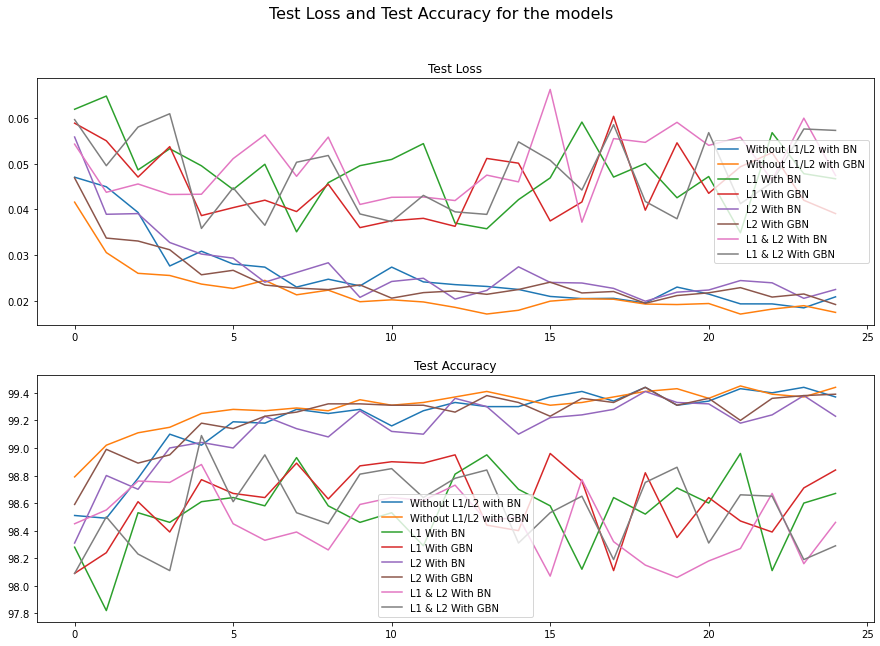

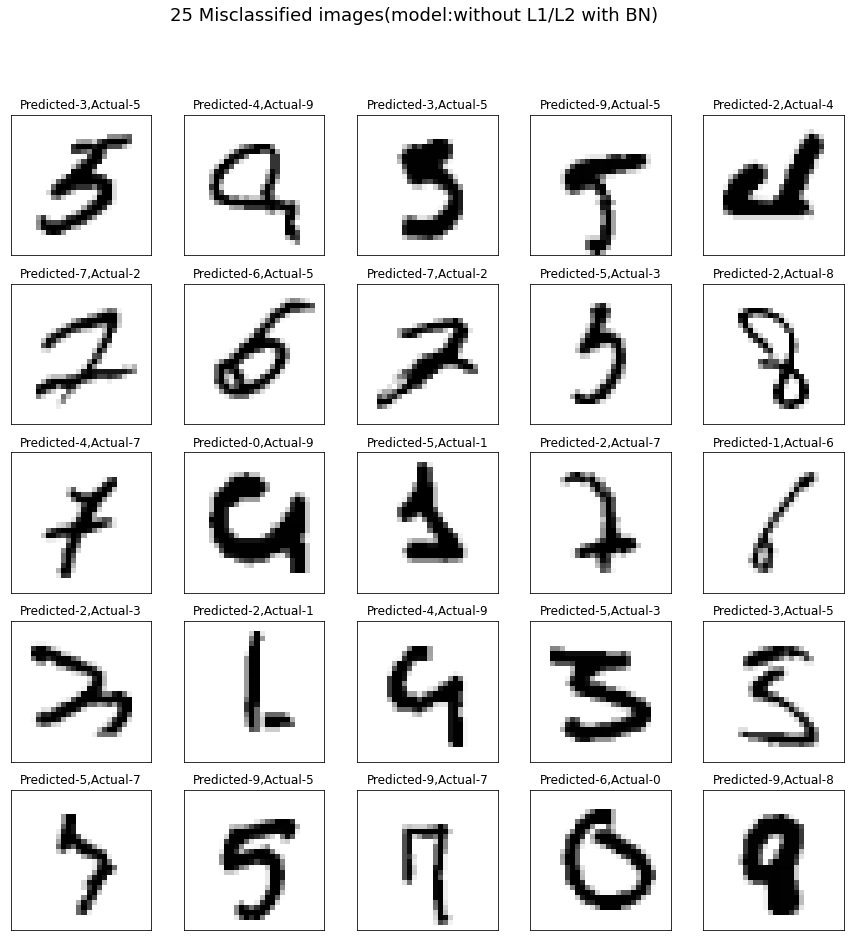

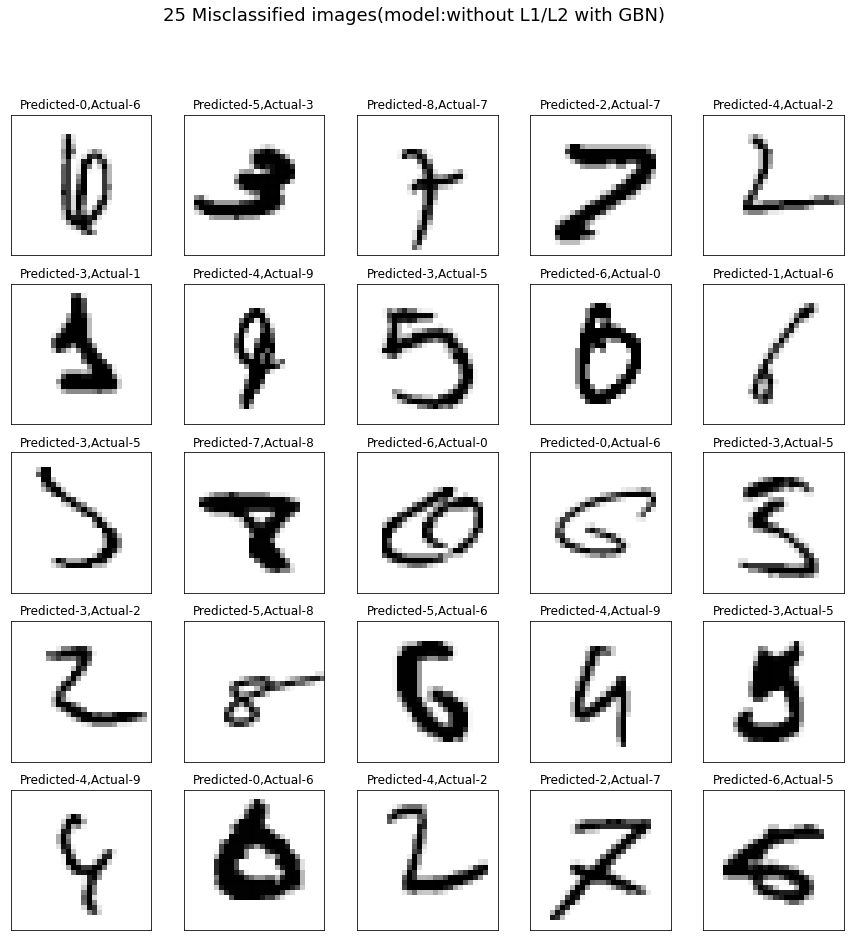

In [12]:
if __name__ == '__main__':
    """
    without L1/L2 with BN
    without L1/L2 with GBN
    with L1 with BN
    with L1 with GBN
    with L2 with BN
    with L2 with GBN
    with L1 and L2 with BN
    with L1 and L2 with GBN
    """

    conditions = {
        'cond1': {
            'condition': "without L1/L2 with BN",
            'req_L1': False,
            'req_L2': False,
            'requiredBN': True,
            'requiredGBN': False,
            'wt_decay': 0
        },
        'cond2': {
            'condition': "without L1/L2 with GBN",
            'req_L1': False,
            'req_L2': False,
            'requiredBN': False,
            'requiredGBN': True,
            'wt_decay': 0.0001
        },
        'cond3': {
            'condition': "with L1 with BN",
            'req_L1': True,
            'req_L2': False,
            'requiredBN': True,
            'requiredGBN': False,
            'wt_decay': 0
        },
        'cond4': {
            'condition': 'with L1 with GBN',
            'req_L1': True,
            'req_L2': False,
            'requiredBN': False,
            'requiredGBN': True,
            'wt_decay': 0.0001
        },
        'cond5': {
            'condition': 'with L2 with BN',
            'req_L1': False,
            'req_L2': True,
            'requiredBN': True,
            'requiredGBN': False,
            'wt_decay': 0
        },
        'cond6': {
            'condition': 'with L2 with GBN',
            'req_L1': False,
            'req_L2': True,
            'requiredBN': False,
            'requiredGBN': True,
            'wt_decay': 0.0001
        },
        'cond7': {
            'condition': 'with L1 and L2 with BN',
            'req_L1': True,
            'req_L2': True,
            'requiredBN': True,
            'requiredGBN': False,
            'wt_decay': 0
        },
        'cond8': {
            'condition': 'with L1 and L2 with GBN',
            'req_L1': True,
            'req_L2': True,
            'requiredBN': False,
            'requiredGBN': True,
            'wt_decay': 0.0001
        }
    }

    main(conditions)